## Tweet Sentiment Extraction

#### Mini Project 3
- Email: yuehangdata@outlook.com
- Let's connect on LinkedIn: [Yue Hang Tan](https://www.linkedin.com/in/yuehangtan/)

## Data Source from Kaggle:
The data set was provided as a Kaggle competition which held in year 2020.

https://www.kaggle.com/competitions/tweet-sentiment-extraction/data

With over 20k rows of training data sets, it can help us to build some basic predictive models that could predict the sentiments of tweets, which can be useful for business applications such as find out the overall sentiment towards the product based on text reviews, identify the specific features of product that are frequently associated with negative sentiment, identify the trends, patterns or changes of sentiments towards the product over time, identify potential influencers (users with many followers) who have tweeted positively about the product, utilize the sentiment analysis results as features to build new ML model and predict the future sales trends etc.

In [53]:
# import system libraries
import os
import time
import warnings
warnings.filterwarnings("ignore")

# import NLP and regex libraries
import spacy
import nltk
import re

# import standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Import text vectorizer and data processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics
from tensorflow.keras.metrics import Recall
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import ML models
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
os.getcwd()

'c:\\Users\\bibih\\Downloads\\Mini Project 3\\Tweet Sentiment Extraction\\Mini Project 3 (Yue Hang)'

In [4]:
os.chdir(r"C:\Users\bibih\Downloads\Mini Project 3\Tweet Sentiment Extraction\Mini Project 3 (Yue Hang)\Data")
os.getcwd()

'C:\\Users\\bibih\\Downloads\\Mini Project 3\\Tweet Sentiment Extraction\\Mini Project 3 (Yue Hang)\\Data'

In [5]:
df = pd.read_csv("train.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### 1. EDA and data cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
# There seems to be a text row where it is NaN
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [8]:
# Identify the row with NaN value in column "text"
df[df["text"].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [9]:
# Drop this row
df.drop(index=314, axis=0, inplace=True)

# Inspect the df again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [10]:
# Drop the "selected_text" and "textID" columns. We will do the text cleaning by ourselves
df.drop(["selected_text", "textID"], axis=1, inplace=True)
df.head(3)

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative


In [11]:
# Define a function to perform data (text) cleaning
def text_clean(df, text):
    """ 
    Note: Make sure to check if there is any float/int contained in the DataFrame before using this function.
    If the df contains any float/int, preprocess it beforehand.
    1. Input a DataFrame with text to be cleaned.
    2. Input the header of the text column
    """
    # Load English tokenizer, tagger, parser, NER and word vectors
    nlp = spacy.load("en_core_web_sm")

    # Change all the text into lower case
    df["Lower Case"] = df[text].apply(lambda x: x.lower() if type(x) == str else x)

    # Remove all the punctuations in the text
    df["Punctuations Removed"] = df["Lower Case"].apply(lambda x: re.sub("\W", " ", x) if type(x) == str else x)

    # Remove multi-spacing and new line into just single-spacing
    df["Spaces Cleaned"] = df["Punctuations Removed"].apply(lambda x: re.sub(r"(\s{2,}|\n{2,})", " ", x))

    # Return the number of characters, excluding spaces
    df["Char Counts"] = df["Punctuations Removed"].apply(lambda x: len([x for item in x if item != " "]))

    # Remove stop words
    df["No Stop Words"] = df["Spaces Cleaned"].apply(lambda x: " ".join(token.text for token in nlp(x) if token.is_stop == False))

    # Lemmatize the strings
    df["Lemmatized"] = df["No Stop Words"].apply(lambda x: " ".join(token.lemma_ for token in nlp(x.strip())))

    # Tokenize the lemmatized string and store in a list, for text vectorization purposes
    df["Tokenized"] = df["Lemmatized"].apply(lambda x: [item for item in nlp(x.strip())])

    # Return the count of words
    df["Word Counts"] = df["Spaces Cleaned"].apply(lambda x: len(x.split()))

    # Word density (average number of characters in a word)
    df["Word Density"] = df["Char Counts"] / df["Word Counts"]

    # Punctuation Counts
    df["Punctuation Counts"] = df["Lower Case"].apply(lambda x: len([item for item in x if item in string.punctuation]))

    # Remove the leading and trailing space(s), and return the tokenized text
    df["Tokenized"] = df["Lemmatized"].apply(lambda x: [item.text for item in nlp(x.strip())])
    df.head()

    return df

In [12]:
%%time
# Preview the cleaned DataFrame
df_cleaned = text_clean(df, "text")
df_cleaned.head()

CPU times: total: 8min 55s
Wall time: 9min 1s


,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going",i d have responded if i were going,i d have responded if i were going,27,d responded going,d respond go,"[d, respond, go]",8,3.375000,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego,33,sooo sad miss san diego,sooo sad miss san diego,"[sooo, sad, miss, san, diego]",10,3.300000,3
2,my boss is bullying me...,negative,my boss is bullying me...,my boss is bullying me,my boss is bullying me,18,boss bullying,boss bully,"[boss, bully]",5,3.600000,3
3,what interview! leave me alone,negative,what interview! leave me alone,what interview leave me alone,what interview leave me alone,25,interview leave,interview leave,"[interview, leave]",5,5.000000,1
4,"Sons of ****, why couldn`t they put them on t...",negative,"sons of ****, why couldn`t they put them on t...",sons of why couldn t they put them on t...,sons of why couldn t they put them on the rel...,55,sons couldn t releases bought,son couldn t release buy,"[son, couldn, t, release, buy]",14,3.928571,6


In [13]:
# Check the DataFrame information
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  27480 non-null  object 
 1   sentiment             27480 non-null  object 
 2   Lower Case            27480 non-null  object 
 3   Punctuations Removed  27480 non-null  object 
 4   Spaces Cleaned        27480 non-null  object 
 5   Char Counts           27480 non-null  int64  
 6   No Stop Words         27480 non-null  object 
 7   Lemmatized            27480 non-null  object 
 8   Tokenized             27480 non-null  object 
 9   Word Counts           27480 non-null  int64  
 10  Word Density          27478 non-null  float64
 11  Punctuation Counts    27480 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.7+ MB


In [14]:
# There seems to be two missing values in Word Density.
# Check what are these two rows
df_cleaned[df_cleaned["Word Density"].isna()]

,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
8120,****,negative,****,,,0,,,[],0,NaN,4
26005,?,neutral,?,,,0,,,[],0,NaN,1


In [15]:
# Apparently the text of these two rows only consist of meaningless symbols, hence there is no word counts
# Drop these two rows
df_cleaned.drop(index=[8120, 26005], axis=0, inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27478 entries, 0 to 27480
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  27478 non-null  object 
 1   sentiment             27478 non-null  object 
 2   Lower Case            27478 non-null  object 
 3   Punctuations Removed  27478 non-null  object 
 4   Spaces Cleaned        27478 non-null  object 
 5   Char Counts           27478 non-null  int64  
 6   No Stop Words         27478 non-null  object 
 7   Lemmatized            27478 non-null  object 
 8   Tokenized             27478 non-null  object 
 9   Word Counts           27478 non-null  int64  
 10  Word Density          27478 non-null  float64
 11  Punctuation Counts    27478 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 2.7+ MB


### 2. Process and split the data

In this notebook the objective is to use conventional ML models, and the workflow is as follow:
1. Vectorize features with pre-trained Word2Vec.
2. Label encode target variable. Note: With label encoding, must use models that do not assume ordinal relationship on label encoded data. (e.g. tree-based estimators)
3. Split the data into train, validation, and test data sets.

In [16]:
# Preview the DataFrame
df_cleaned.head(3)

,text,sentiment,Lower Case,Punctuations Removed,Spaces Cleaned,Char Counts,No Stop Words,Lemmatized,Tokenized,Word Counts,Word Density,Punctuation Counts
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going",i d have responded if i were going,i d have responded if i were going,27,d responded going,d respond go,"[d, respond, go]",8,3.375,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego,33,sooo sad miss san diego,sooo sad miss san diego,"[sooo, sad, miss, san, diego]",10,3.300,3
2,my boss is bullying me...,negative,my boss is bullying me...,my boss is bullying me,my boss is bullying me,18,boss bullying,boss bully,"[boss, bully]",5,3.600,3


2.1 Define the features and target variable.

In [17]:
X = df_cleaned["Lemmatized"]
y = df_cleaned["sentiment"]

In [18]:
X = X.to_list()
X[:5]

['d respond go',
 'sooo sad miss san diego',
 'boss bully',
 'interview leave',
 'son couldn t release buy']

In [19]:
# Need to first convert y into numbers before we can use to_categorical
y = y.apply(lambda x: 0 if x == "neutral" else 1 if x == "positive" else 2 if x == "negative" else x)
y[:5]

0    0
1    2
2    2
3    2
4    2
Name: sentiment, dtype: int64

In [20]:
y = to_categorical(y, num_classes=3)
y[:3]

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [21]:
len(X), len(y)

(27478, 27478)

2.2 Tokenize the text

In [22]:
# Instantiate Keras Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X)

# Assign sequence to each individual token
sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences so that all the sequences are of the same length for DNN
padded_sequences = pad_sequences(sequences, maxlen=100)

# Return the the word index
word_index = tokenizer.word_index

2.3 Vectorize the text with pre-trained Word2Vec

In [24]:
os.chdir(r"C:\Users\bibih\Documents\Application documents\Data Science Career\Courses\Institute of Data\Classroom Materials\Google Word2Vec Pretrained Model")
os.getcwd()

'C:\\Users\\bibih\\Documents\\Application documents\\Data Science Career\\Courses\\Institute of Data\\Classroom Materials\\Google Word2Vec Pretrained Model'

In [25]:
# Load vectors directly from the file
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
word_vectors

In [26]:
# Create matrices with all zeros for embedding purposes
# Embedding is needed for Word2Vec in order to convert the text into dense vector of fixed size that LSTM neural network can work with
embedding_matrix = np.zeros((len(word_index) + 1, word_vectors.vector_size))

In [27]:
# Preview the matrices with all zeros
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# Replace some of the zeros in the matrices with word vectors
for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

In [29]:
# Preview the matrices after replacing with word vectors
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.29101562,  0.17871094,  0.05004883, ..., -0.02282715,
         0.11767578,  0.35351562],
       [-0.15332031,  0.16894531, -0.04711914, ...,  0.11621094,
        -0.03222656, -0.17578125],
       ...,
       [ 0.37890625, -0.29296875, -0.12597656, ..., -0.12451172,
        -0.16796875, -0.04174805],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12011719, -0.05957031,  0.11328125, ...,  0.07666016,
        -0.10009766, -0.0703125 ]])

In [30]:
# Pad the vectors / matrices to make them equally long, for LSTM neural network training later
padded_sequences

array([[   0,    0,    0, ...,   72, 1177,    5],
       [   0,    0,    0, ...,   20, 1130, 1869],
       [   0,    0,    0, ...,    0,    0, 1004],
       ...,
       [   0,    0,    0, ...,   64,  410,  647],
       [   0,    0,    0, ...,    0,    0,  509],
       [   0,    0,    0, ...,  424,  135,  303]])

In [31]:
# Split the data into training, validation and test sets
# Split X and y into train, validation, and test data sets
X_temp, X_test, y_temp, y_test = train_test_split(padded_sequences, y, test_size=0.2, shuffle=True, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=True, random_state=42)

### 3. ML Modelling with LSTM neural networks

In [32]:
# Build the model
model = Sequential()

# Add embedding 
model.add(Embedding(len(word_index) + 1, word_vectors.vector_size, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[Recall(name="recall")])

In [33]:
# Specify the location to save the weights
checkpoint = ModelCheckpoint("best_model_3", monitor="val_recall", verbose=1, save_best_only=True, mode="max")

In [36]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
%%time
fitting = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_val, y_val), verbose=1, callbacks=[checkpoint])

Epoch 1/15
275/275 [==============================] - ETA: 0s - loss: 0.7539 - recall: 0.6059
Epoch 1: val_recall improved from -inf to 0.58563, saving model to best_model_3
INFO:tensorflow:Assets written to: best_model_3\assets
275/275 [==============================] - 113s 409ms/step - loss: 0.7539 - recall: 0.6059 - val_loss: 0.7708 - val_recall: 0.5856
Epoch 2/15
275/275 [==============================] - ETA: 0s - loss: 0.7109 - recall: 0.6363
Epoch 2: val_recall improved from 0.58563 to 0.65545, saving model to best_model_3
INFO:tensorflow:Assets written to: best_model_3\assets
275/275 [==============================] - 111s 405ms/step - loss: 0.7109 - recall: 0.6363 - val_loss: 0.7180 - val_recall: 0.6554
Epoch 3/15
275/275 [==============================] - ETA: 0s - loss: 0.6870 - recall: 0.6564
Epoch 3: val_recall improved from 0.65545 to 0.66159, saving model to best_model_3
INFO:tensorflow:Assets written to: best_model_3\assets
275/275 [==============================] - 11

### 4. Evaluate the model

4.1 Recall and Loss over Epochs

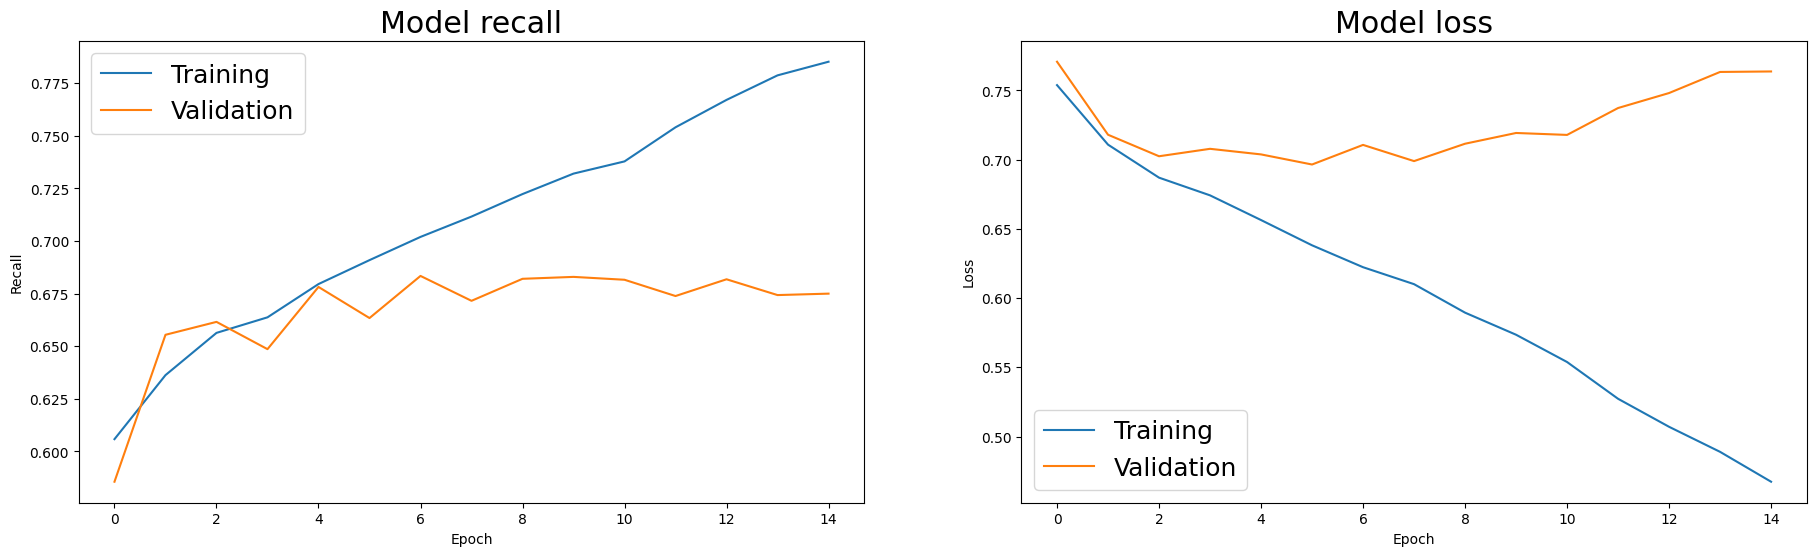

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(fitting.history['recall'], label = 'Training')
ax[0].plot(fitting.history['val_recall'], label = 'Validation')
ax[0].set_title('Model recall')
ax[0].set_ylabel('Recall')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(fitting.history['loss'], label = 'Training')
ax[1].plot(fitting.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

4.2 Compute the Metrics

In [41]:
# Return the mbest model
model = load_model("best_model_3")

In [42]:
y_pred = model.predict(X_test)

172/172 [==============================] - 8s 48ms/step


In [43]:
# Both y_pred and y_test are one-hot encoded arrays, which may not work for certain processing like confusion matrix
# Therefore convert both y_pred and y_test into multiclass arrays
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

In [44]:
# Compute accuracy score
accuracy_test = accuracy_score(y_test_multiclass, y_pred_multiclass)
accuracy_test

0.7183406113537117

In [45]:
# Compute precision score
precision_test = precision_score(y_test_multiclass, y_pred_multiclass, average="macro")
precision_test

0.7403225381675345

In [46]:
# Compute recall score
recall_test = recall_score(y_test_multiclass, y_pred_multiclass, average="macro")
recall_test

0.7064314700670097

In [47]:
# Compute F1 score
f1_test = f1_score(y_test_multiclass, y_pred_multiclass, average="macro")
f1_test

0.716526764269143

In [48]:
final_results = pd.DataFrame({
    "Accuracy": [accuracy_test],
    "Precision": [precision_test],
    "Recall": [recall_test],
    "F1": [f1_test]
}, index=["Score"])

final_results

,Accuracy,Precision,Recall,F1
Score,0.718341,0.740323,0.706431,0.716527


4.3 ROC Curve

In [49]:
y_score = model.predict(X_test)
y_score

172/172 [==============================] - 7s 41ms/step


array([[0.07963222, 0.89969784, 0.02066996],
       [0.05137717, 0.78926253, 0.15936032],
       [0.859638  , 0.08019633, 0.06016573],
       ...,
       [0.4987228 , 0.3365934 , 0.1646838 ],
       [0.86532533, 0.02708042, 0.10759428],
       [0.07835954, 0.9104874 , 0.01115306]], dtype=float32)

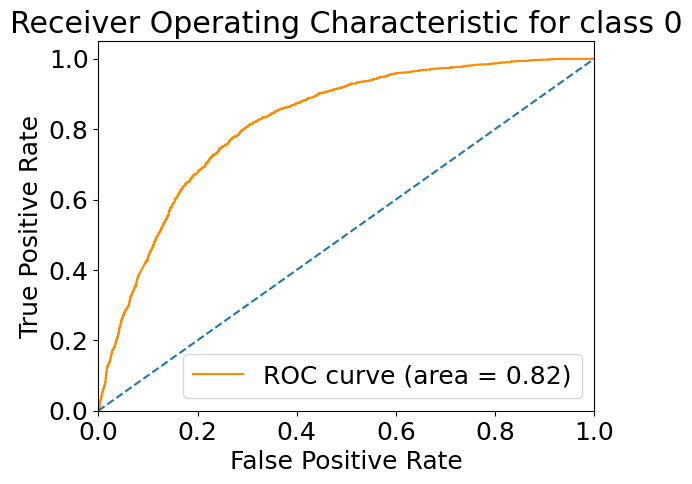

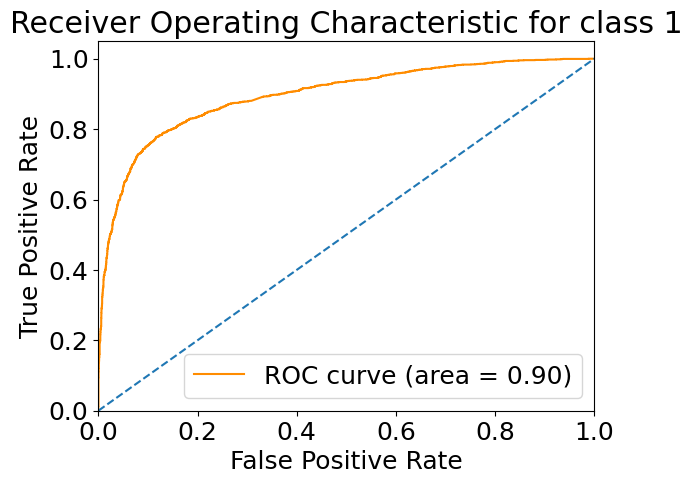

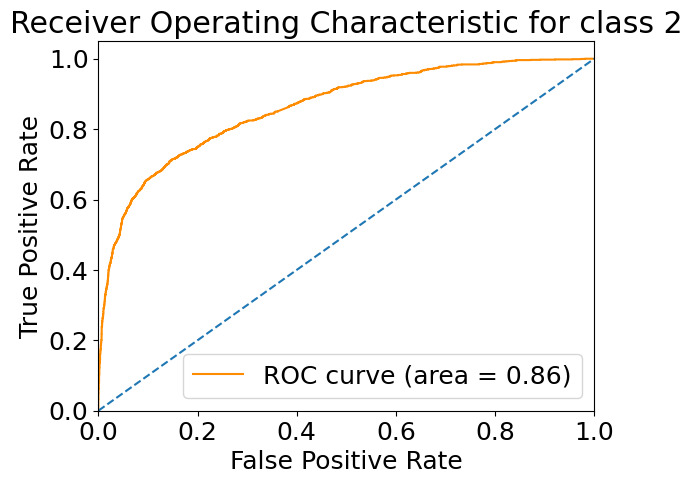

In [50]:
# Credits: Copilot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# y_score is the output of predict_proba()

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color="darkorange", label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class %i' % i)
    plt.legend(loc="lower right")
    plt.show()


4.4 Confusion Matrix

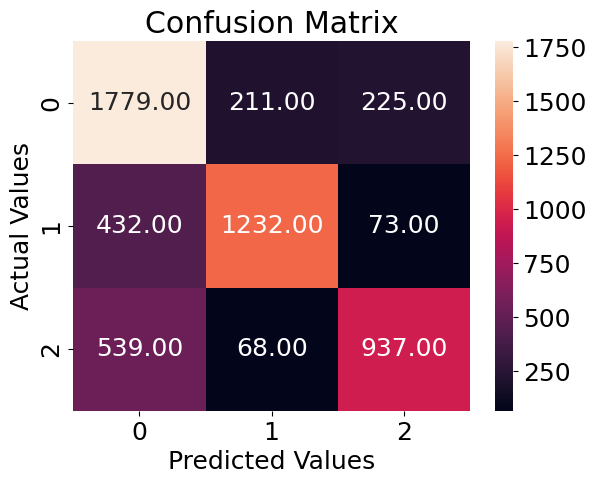

In [51]:
# Now we can compute the confusion matrix.
# Credits: Copilot
cf = pd.DataFrame(confusion_matrix(y_test_multiclass, y_pred_multiclass))
sns.heatmap(data=cf, annot=True, fmt=".2f")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix")
plt.show();

#### Discussions:
#### 1. Check out the PowerPoint presentation slide deck for more discussions and comparisons on the models and analysis.